<b><u>Observations</b></u>
<p>1. observation</p>
<p>2. observation</p>
<p>3. observation</p>

In [1]:
# Dependencies
import random
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import seaborn as sns
from citipy import citipy
import matplotlib.pyplot as plt

# Set the seaborn chart style
sns.set()

# Dependencies for downloading and uncompressing list of cities from OpenWeatherMap
import urllib.request
import gzip

<h1>Download City List</h1>

In [2]:
# This section downloads the list of cities and IDs that OpenWeatherMap uses

# File names
city_index_zip_file = "city.list.json.gz"
city_index_json_file = 'city.list.json'

# Download file
urllib.request.urlretrieve ("http://bulk.openweathermap.org/sample/city.list.json.gz", city_index_zip_file)

# Uncompress gzip file to json
inF = gzip.open(city_index_zip_file, 'rb')
outF = open(city_index_json_file, 'wb')
outF.write( inF.read() )
inF.close()
outF.close()

# Read json file into a dataframe
city_index_df = pd.read_json(city_index_json_file)

# Print top five rows
city_index_df.head()

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,GorkhÄ�
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of HaryÄ�na
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


<h1>Generate City List</h1>

In [6]:
# This section selects 500 random cities from the city index list

# Start by creating an empty dataframe
random_city_df = pd.DataFrame(columns=['coord', 'country', 'id', 'name', 'lon', 'lat'])

# Set counter to zero for looping
counter = 0

# Set total number of random cities
total_cities = 5

# Loop while counter is less than number of cities
while counter < total_cities:
    
    # Pick a random row (must be length - 1 since row starts at 0)
    row = random.randint(0, len(city_index_df)-1)
    
    # If ID is already in the list then do nothing repeat loop
    if any(random_city_df.id == city_index_df['id'][row]):
        pass
    
    # If ID isn't in the list then add that row to the dataframe, including latitude and longitude
    else:
        random_city_df.loc[counter] = city_index_df.iloc[row,:]
        random_city_df.lat[counter] = city_index_df['coord'][row]['lat']
        random_city_df.lon[counter] = city_index_df['coord'][row]['lon']
        counter = counter + 1
        
# Change latitude and longitude columns from object to float
random_city_df[['lat','lon']] = random_city_df[['lat','lon']].apply(pd.to_numeric)

# Remove coordinate column, since we parsed out that data
del random_city_df['coord']

print(random_city_df)

  country       id              name         lon        lat
0      DE  2871703         Merzalben    7.730770  49.244671
1      GB  2649013         Froxfield   -1.572030  51.410820
2      AT  2768580  PÃ¶llau am Greim   14.166670  47.200001
3      DE  2930965        Ellerstadt    8.259440  49.461670
4      PH  1701799           Mangero  122.677498  13.270280


<h1>Weather API Call</h1>

In [16]:
city_temp_list = []
city_humidity_list = []
city_cloudiness_list = []
city_windspeed_list = []

for x in range(total_cities):
    print(f"Request {x+1} of {total_cities}: {random_city_df['name'][x]}")
    
    url = "http://api.openweathermap.org/data/2.5/weather?APPID="+api_key+"&units=imperial&id="+str(random_city_df.id[x])
    print(url)

    response = requests.get(url)
    data = response.json()
    
    city_temp_list.append(data['main']['temp'])
    city_humidity_list.append(data['main']['humidity'])
    city_cloudiness_list.append(data['clouds']['all'])
    city_windspeed_list.append(data['wind']['speed'])

random_city_df['temp'] = city_temp_list
random_city_df['humidity'] = city_humidity_list
random_city_df['cloudiness'] = city_cloudiness_list
random_city_df['windspeed'] = city_windspeed_list

random_city_df

Request 1 of 5: Merzalben
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2871703
Request 2 of 5: Froxfield
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2649013
Request 3 of 5: PÃ¶llau am Greim
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2768580
Request 4 of 5: Ellerstadt
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2930965
Request 5 of 5: Mangero
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1701799


,country,id,name,lon,lat,fahrenheit,temp,humidity,cloudiness,windspeed
0,DE,2871703,Merzalben,7.730770,49.244671,52.70,51.84,53,1,10.29
1,GB,2649013,Froxfield,-1.572030,51.410820,47.30,47.30,81,75,4.70
2,AT,2768580,PÃ¶llau am Greim,14.166670,47.200001,47.35,46.49,42,0,6.93
3,DE,2930965,Ellerstadt,8.259440,49.461670,51.80,51.21,43,0,5.82
4,PH,1701799,Mangero,122.677498,13.270280,79.80,79.80,100,76,21.85


In [15]:
pprint(data)

{'base': 'stations',
 'clouds': {'all': 76},
 'cod': 200,
 'coord': {'lat': 13.27, 'lon': 122.68},
 'dt': 1521903856,
 'id': 1701799,
 'main': {'grnd_level': 1025.57,
          'humidity': 100,
          'pressure': 1025.57,
          'sea_level': 1028.21,
          'temp': 79.8,
          'temp_max': 79.8,
          'temp_min': 79.8},
 'name': 'Mangero',
 'sys': {'country': 'PH',
         'message': 0.0042,
         'sunrise': 1521841839,
         'sunset': 1521885625},
 'weather': [{'description': 'broken clouds',
              'icon': '04n',
              'id': 803,
              'main': 'Clouds'}],
 'wind': {'deg': 44.5008, 'speed': 21.85}}


<h1>Print Charts</h1>

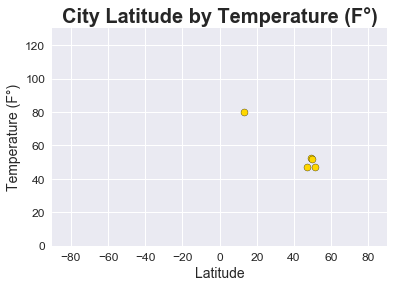

In [14]:
# This section prints a scatter plot of latitude by temperature

plt.clf()

# Create bubble plots
plt.scatter(random_city_df['lat'], random_city_df['temp'], marker="o", facecolors='gold', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Temperature (F\N{DEGREE SIGN})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Temperature (F\N{DEGREE SIGN})", fontsize=14)

#plt.colorbar()

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(0,130)

# Save the figure
#plt.savefig("LatByTemp.png")

# Display bubble chart
plt.show()

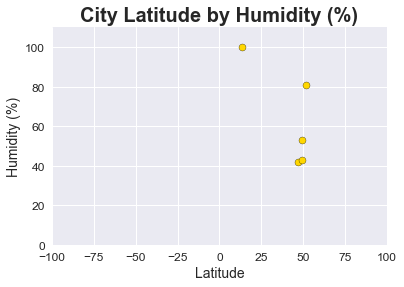

In [20]:
plt.clf()

# Create bubble plots
plt.scatter(random_city_df['lat'], random_city_df['humidity'], marker="o", facecolors='gold', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Humidity (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

#plt.colorbar()

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(0,110)

# Save the figure
#plt.savefig("LatByTemp.png")

# Display bubble chart
plt.show()

In [ ]:
plt.clf()

# Create bubble plots
plt.scatter(random_city_df['lat'], random_city_df['cloudiness'], marker="o", facecolors='gold', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Humidity (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

#plt.colorbar()

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(0,110)

# Save the figure
#plt.savefig("LatByTemp.png")

# Display bubble chart
plt.show()

<h1>Export Results</h1>